In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
basedir = './prepped_data/'

In [3]:
%%time
main_data_df = pd.read_csv(basedir + 'main_data_baseline_checkpoint_3.csv')
print(main_data_df.shape)
main_data_df.head()

(4441256, 18)
Wall time: 6.02 s


,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,도로명주소,X좌표,Y좌표,주택가격지수
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.100
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.213
2,매매,77.75,29,55000,0,7,1988,707.395498,2014,1,10.915088,6.561590,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,79.451
3,매매,77.75,10,59500,0,4,1988,765.273312,2014,11,10.993732,6.640233,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,82.100
4,매매,77.75,28,75000,0,5,1988,964.630225,2016,3,11.225243,6.871745,아파트,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,960473.743425,1.942553e+06,89.466


<AxesSubplot:>

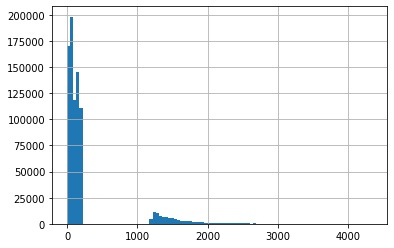

In [4]:
outlier_df = main_data_df[(main_data_df['가격/면적'] < 200)|(main_data_df['가격/면적'] > 1200)]
outlier_df['가격/면적'].hist(bins=100)

In [5]:
main_data_df = main_data_df.drop(outlier_df.index).reset_index(drop=True)

In [6]:
%%time
land_prices_df = pd.read_csv(basedir + 'land_prices_ver_2.csv')
land_prices_df.shape

Wall time: 592 ms


(1594565, 4)

In [7]:
%%time
land_specs_df = pd.read_csv(basedir + 'land_specs_ver_3.csv')
land_specs_df.shape

Wall time: 1.6 s


(1563645, 11)

In [8]:
%%time
land_plans_df = pd.read_csv(basedir + 'land_plans_ver_3.csv')
land_plans_df.shape

<string>:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,27

Wall time: 26.7 s


(1565190, 288)

In [9]:
land_plans_df.fillna('해당사항없음', inplace=True)

In [10]:
%%time
bdinfo_df = pd.read_csv(basedir + 'extracted_building_features.csv')
bdinfo_df.shape

Wall time: 14.1 s


(1453497, 276)

In [11]:
%%time
bdarea_df = pd.read_csv(basedir + 'bdinfo_wbdinfo_area.csv')
bdarea_df.drop(columns=['사용승인년도'], inplace=True)
bdarea_df.rename(columns={'기준년도':'년'}, inplace=True)
print(bdarea_df.shape)
bdarea_df.head()

(1438766, 3)
Wall time: 550 ms


,지번주소,년,연면적
0,서울특별시 마포구 서교동 484-16,2006,393.13
1,서울특별시 마포구 서교동 484-16,2007,393.13
2,서울특별시 마포구 서교동 484-16,2008,393.13
3,서울특별시 마포구 서교동 484-16,2009,393.13
4,서울특별시 마포구 서교동 484-16,2010,393.13


In [12]:
%%time
bdsubnum_df = pd.read_csv(basedir + 'bdinfo_wbdinfo_subnum.csv')
bdsubnum_df.rename(columns={'기준년도':'년'}, inplace=True)
print(bdsubnum_df.shape)
bdsubnum_df.head()

(1438766, 3)
Wall time: 424 ms


,지번주소,년,부속건축물수
0,서울특별시 마포구 서교동 484-16,2006,0.0
1,서울특별시 마포구 서교동 484-16,2007,0.0
2,서울특별시 마포구 서교동 484-16,2008,0.0
3,서울특별시 마포구 서교동 484-16,2009,0.0
4,서울특별시 마포구 서교동 484-16,2010,0.0


In [13]:
dfs_list = [main_data_df, land_prices_df, land_specs_df, land_plans_df, bdinfo_df, bdarea_df, bdsubnum_df]
for df in dfs_list:
    print(df.shape)

(3602274, 18)
(1594565, 4)
(1563645, 11)
(1565190, 288)
(1453497, 276)
(1438766, 3)
(1438766, 3)


In [14]:
main_data_df.rename(columns={'전용면적(㎡)':'전용면적'}, inplace=True)

In [15]:
%%time
main_data_df['전용면적_mean'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('mean')['전용면적']
main_data_df['전용면적_min'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('min')['전용면적']
main_data_df['전용면적_max'] = main_data_df[['지번주소', '건축년도', '전용면적']].groupby(['지번주소', '건축년도']).transform('max')['전용면적']

Wall time: 1.41 s


In [16]:
main_data_df = main_data_df[((main_data_df['전월세매매구분'] == '매매')|(main_data_df['전월세매매구분'] == '전세'))].drop(columns=['월세(만원)', '도로명주소'])
print(main_data_df.shape)

(3351110, 19)


In [17]:
main_data_df['건물나이'] = main_data_df['년'] - main_data_df['건축년도']
main_data_df['건물나이'].describe()

count    3.351110e+06
mean     1.371413e+01
std      9.717475e+00
min     -1.200000e+01
25%      6.000000e+00
50%      1.300000e+01
75%      2.000000e+01
max      8.900000e+01
Name: 건물나이, dtype: float64

In [18]:
main_data_df.drop(columns=['건축년도'], inplace=True)

In [19]:
main_data_df['year_linear'] = (main_data_df['년'] - main_data_df['년'].min()) + ((main_data_df['월']-1)/12)

In [20]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [21]:
main_data_df['month_sin'] = main_data_df['월'].apply(month_circular_sine_func)
main_data_df['month_cos'] = main_data_df['월'].apply(month_circular_cosine_func)

In [22]:
main_data_df.drop(columns=['월', '계약일'], inplace=True)

In [23]:
xmax = main_data_df['X좌표'].max()
xmin = main_data_df['X좌표'].min()
ymax = main_data_df['Y좌표'].max()
ymin = main_data_df['Y좌표'].min()

In [24]:
coor_minmax_df = pd.DataFrame({'xmax':xmax, 'xmin':xmin, 'ymax':ymax, 'ymin':ymin}, index=[0])
coor_minmax_df.to_csv('./Training/training_data_ver_14/coor_minmax.csv', index=False)
coor_minmax_df

,xmax,xmin,ymax,ymin
0,971728.508488,938089.149737,1.965830e+06,1.937374e+06


In [25]:
main_data_df['xnorm'] = (main_data_df['X좌표'] - xmin - ((xmax - xmin)/2)) / 10000
main_data_df['ynorm'] = (main_data_df['Y좌표'] - ymin - ((ymax - ymin)/2)) / 10000
main_data_df['x_2nd'] = main_data_df['xnorm']**2 / 2
main_data_df['y_2nd'] = main_data_df['ynorm']**2 / 2
main_data_df['x_sin'] = main_data_df['xnorm'].apply(np.sin)
main_data_df['y_sin'] = main_data_df['ynorm'].apply(np.sin)
main_data_df['x_cos'] = main_data_df['xnorm'].apply(np.cos)
main_data_df['y_cos'] = main_data_df['ynorm'].apply(np.cos)
main_data_df['xy'] = main_data_df['xnorm'] * main_data_df['ynorm']

In [26]:
main_data_df.drop(columns=['X좌표', 'Y좌표'], inplace=True)

In [27]:
main_data_df['trade_type'] = main_data_df['건물종류'] + '_' + main_data_df['전월세매매구분']
main_data_df.drop(columns=['건물종류', '전월세매매구분'], inplace=True)

In [28]:
merge1_df = main_data_df.merge(land_prices_df, on=['지번주소', '년'])
merge1_df.shape

(3250850, 28)

In [29]:
merge1_df['공시지가'] = merge1_df['공시지가'] / 10000
merge1_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [30]:
bdinfo_df.drop(columns=['사용승인년도'], inplace=True)
bdinfo_df.rename(columns={'기준년도':'년'}, inplace=True)

In [31]:
merge1_df.shape

(3250850, 28)

In [32]:
merge2_df = merge1_df.merge(bdinfo_df, on=['지번주소', '년'])
merge2_df.shape

(3237276, 301)

In [33]:
merge2_df['최고층-층'] = merge2_df['층max'] - merge2_df['층']
merge2_df['최고층-층'].describe()

count    3.237276e+06
mean     6.650021e+00
std      6.366630e+00
min     -2.700000e+01
25%      2.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      6.800000e+01
Name: 최고층-층, dtype: float64

In [34]:
negative_df = merge2_df[merge2_df['최고층-층'] < 0]
negative_df.shape

(5989, 302)

In [35]:
negative_df['지번주소'].nunique()

174

In [36]:
idx_to_drop = []
for addr in tqdm(negative_df['지번주소'].unique()):
    addr_df = merge2_df[merge2_df['지번주소'] == addr]
    addr2_df = negative_df[negative_df['지번주소'] == addr]
    min_year = addr2_df['년'].min()
    df_to_drop = addr_df[addr_df['년'] >= min_year]
    for idx in df_to_drop.index:
        idx_to_drop.append(idx)

100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:19<00:00,  8.79it/s]


In [37]:
merge2_df.drop(idx_to_drop, inplace=True)

In [38]:
len(list(set(idx_to_drop)))

33856

In [39]:
merge2_df.shape

(3203420, 302)

In [40]:
merge2_df['최고층-층'].describe()

count    3.203420e+06
mean     6.668747e+00
std      6.361399e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      6.800000e+01
Name: 최고층-층, dtype: float64

In [41]:
merge2_df['최고층-층norm'] = merge2_df['최고층-층'] / merge2_df['층max']

In [42]:
merge2_df['최고층-층norm'].describe()

count    3.203420e+06
mean     4.569568e-01
std      2.889804e-01
min      0.000000e+00
25%      2.173913e-01
50%      4.666667e-01
75%      6.666667e-01
max      2.000000e+00
Name: 최고층-층norm, dtype: float64

In [43]:
merge2_df.drop(columns=['최고층-층'], inplace=True)

In [44]:
cols = [col for col in land_specs_df.columns if col != '공시지가']
cols

['지번주소',
 '년',
 '지목명',
 '토지면적',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [45]:
merge2_df = merge2_df.merge(land_specs_df[cols], on=['지번주소', '년'])
merge2_df.shape

(3203416, 310)

In [46]:
del merge1_df, main_data_df, land_specs_df, land_prices_df, bdinfo_df
gc.collect()

86

In [47]:
merge2_df = merge2_df.merge(bdarea_df, on=['지번주소', '년'])
merge2_df.shape

(3203416, 311)

In [48]:
merge2_df['연면적'].describe()

count    3.203416e+06
mean     1.030722e+06
std      2.817753e+07
min      0.000000e+00
25%      8.433300e+02
50%      2.972040e+04
75%      1.057131e+05
max      8.516342e+08
Name: 연면적, dtype: float64

In [49]:
merge2_df['토지면적'].describe()

count    3.203416e+06
mean     2.391948e+04
std      4.077676e+04
min      1.000000e+00
25%      3.210000e+02
50%      5.854400e+03
75%      3.072970e+04
max      3.926520e+05
Name: 토지면적, dtype: float64

In [50]:
merge2_df = merge2_df[merge2_df['연면적'] > 0]
merge2_df.shape

(3201217, 311)

In [51]:
merge2_df['연면적'].describe()

count    3.201217e+06
mean     1.031430e+06
std      2.818719e+07
min      3.018000e+01
25%      8.472000e+02
50%      2.975822e+04
75%      1.057701e+05
max      8.516342e+08
Name: 연면적, dtype: float64

In [52]:
merge2_df['토지면적대연면적비'] = merge2_df['토지면적'] / merge2_df['연면적']

In [53]:
merge2_df['토지면적대연면적비'].describe()

count    3.201217e+06
mean     3.318486e-01
std      2.517780e-01
min      6.507507e-06
25%      2.133384e-01
50%      3.060589e-01
75%      4.436872e-01
max      3.435870e+01
Name: 토지면적대연면적비, dtype: float64

In [54]:
max_df = merge2_df[merge2_df['토지면적대연면적비'] == merge2_df['토지면적대연면적비'].max()]
max_df

,전용면적,금액(만원),층,가격/면적,년,target_log_transformed,target/area_log_transformed,지번주소,주택가격지수,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,enviro_mean,enviro_max,enviro_min,epi_mean,epi_max,epi_min,주_용도_부대시설_있음,주_용도_주차장_있음,주_용도_복리시설_있음,주_용도_사무소_있음,주_용도_소매점_있음,주_용도_차고_있음,주_용도_일반음식점_있음,주_용도_기타제1종근생활시설_있음,주_용도_기타제2종근생활시설_있음,주_용도_기타근린생활시설_있음,주_용도_기타창고시설_있음,주_용도_기타판매시설_있음,주_용도_기타일반업무시설_있음,주_용도_기타사무소_있음,주_용도_유치원_있음,주_용도_노인복지시설_있음,주_용도_치과의원_있음,주_용도_의원_있음,주_용도_제조업소_있음,주_용도_대피소_있음,주_용도_휴게음식점_있음,주_용도_학원_있음,주_용도_생활편익시설_있음,주_용도_세탁소_있음,주_용도_창고_있음,주_용도_독서실_있음,주_용도_기타노유자시설_있음,주_용도_부동산중개업소_있음,주_용도_기원_있음,주_용도_기타교육연구시설_있음,주_용도_이(미)용원_있음,주_용도_멀티미디어문화컨텐츠설비제공업소_있음,주_용도_기타자동차관련시설_있음,주_용도_어린이집_있음,주_용도_한의원_있음,주_용도_금융업소_있음,주_용도_일반게임제공업의시설_있음,주_용도_파출소_있음,주_용도_인터넷컴퓨터게임시설제공업소_있음,주_용도_상점_있음,주_용도_게임제공업소_있음,주_용도_기타교육연구및복지시설_있음,주_용도_출판사_있음,주_용도_일반목욕장_있음,주_용도_공중화장실_있음,주_용도_부동산중개사무소_있음,주_용도_미용원_있음,주_용도_기타아동관련시설_있음,주_용도_기타공장_있음,주_용도_수리점_있음,주_용도_영유아보육시설_있음,주_용도_연구소_있음,주_용도_체육도장_있음,주_용도_지역아동센터_있음,주_용도_체육장_있음,주_용도_기타종교집회장_있음,주_용도_기타 운동시설_있음,주_용도_노래연습장_있음,주_용도_당구장_있음,주_용도_기타의료시설_있음,주_용도_아동복지시설_있음,주_용도_의약품도매점_있음,주_용도_교회_있음,주_용도_단란주점_있음,주_용도_조산원_있음,주_용도_침술원_있음,주_용도_표구점_있음,주_용도_목욕장_있음,주_용도_기타운동시설_있음,주_용도_기타문화및집회시설_있음,주_용도_기타전시장_있음,주_용도_사진관_있음,주_용도_기타일반숙박시설_있음,주_용도_체력단련장_있음,주_용도_가족호텔_있음,주_용도_조산소_있음,주_용도_접골원_있음,주_용도_기타생활권수련시설_있음,주_용도_기타공연장_있음,주_용도_탁구장_있음,주_용도_시장_있음,주_용도_직업훈련소_있음,주_용도_기타집회장_있음,주_용도_골프연습장_있음,주_용도_교육(연수)원_있음,주_용도_결혼상담소_있음,주_용도_인터넷컴퓨터게임시설제공업의시설_있음,주_용도_기타종교시설_있음,주_용도_사회복지시설_있음,주_용도_기타공공시설_있음,주_용도_기타판매및영업시설_있음,주_용도_사찰_있음,주_용도_의약품판매소_있음,주_용도_의료기기판매소_있음,주_용도_청소년게임제공업의시설_있음,주_용도_이용원_있음,주_용도_서점(1종근.생미해당)_있음,주_용도_기타위락시설_있음,주_용도_마을공동시설_있음,주_용도_기타위험물저장처리시설_있음,주_용도_변전소_있음,주_용도_병원_있음,주_용도_동물병원_있음,주_용도_유흥주점_있음,주_용도_예식장_있음,주_용도_일반업무시설_있음,주_용도_기타발전시설_있음,주_용도_수퍼마켓_있음,주_용도_공공도서관_있음,주_용도_자동차영업소_있음,주_용도_제1종근린생활시설_있음,주_용도_분뇨처리시설_있음,주_용도_기타소매시장_있음,주_용도_온실_있음,주_용도_소매시장_있음,주_용도_안마시술소_있음,주_용도_야외극장_있음,주_용도_창고시설_있음,주_용도_에어로빅장_있음,주_용도_제2종근린생활시설_있음,주_용도_극장_있음,주_용도_한방병원_있음,주_용도_극장(영화관)_있음,주_용도_기타병원_있음,주_용도_제과점_있음,주_용도_교육연구시설_있음,주_용도_대형백화점_있음,주_용도_기타분뇨쓰레기처리시설_있음,주_용도_총포판매사_있음,주_용도_일반공장_있음,주_용도_기타공공업무시설_있음,주_용도_정수장_있음,주_용도_일반창고_있음,주_용도_운동장시설_있음,주_용도_여관_있음,주_용도_대형점_있음,주_용도_고시원_있음,주_용도_유원시설업의시설_있음,주_용도_무도장_있음,주_용도_치과병원_있음,주_용도_안마원_있음,주_용도_관광호텔_있음,주_용도_도서관_있음,주_용도_비디오물감상실_있음,주_용도_볼링장_있음,주_용도_교육원_있음,주_용도_마을공동작업소_있음,주_용도_산부인과병원_있음,주_용도_대학_있음,주_용도_주점영업_있음,주_용도_소개업_있음,주_용도_요양병원_있음,주_용도_수족관_있음,주_용도_매매장_있음,주_용도_테니스장_있음,주_용도_동사무소_있음,주_용도_무도장(학원)_있음,주_용도_대학교_있음,주_용도_호텔_있음,주_용도_운동시설_있음,주_용도_복합유통게임제공업의시설_있음,주_용도_영화관_있음,주_용도_기숙사_있음,주_용도_체육관_있음,주_용도_도매시장_있음,주_용도_정비공장_있음,주_용도_복합유통게임제공업소_있음,주_용도_회의장_있음,주_용도_총포판매소_있음,주_용도_미술관_있음,주_용도_백화점_있음,주_용도_기타학교_있음,주_용도_공관_있음,주_용도_군사시설_있음,주_용도_방송국_있음,주_용도_기타제2종근린생활시설_있음,주_용도_기타제1종근린생활시설_있음,주_용도_기타동식물관련시설_있음,주_용도_고압가스충전저장소_있음,주_용도_검사장_있음,주_용도_초등학교_있음,주_용도_기타관광숙박시설_있음,주_용도_세차장_있음,주_용도_성당_있음,주_용도_축사_있음,주_용도_기타관광휴게시설_있음,주_용도_위험물취급소_있음,주_용도_석유판매소_있음,주_용도_물놀이형시설_있음,주_용도_보건소_있음,주_용도_고등학교_있음,주_용도_유해공장_있음,주_용도_주유소_있음,주_용도_다중생활시설_있음,주_용도_일반숙박시설_있음,주_용도_호스텔_있음,주_용도_박물관_있음,주_용도_생활숙박시설_있음,주_용도_청소년문화의집_있음,주_용도_근린생활시설_있음,주_용도_산후조리원_있음,주_용도_교습소_있음,주_용도_청소년게임제공업소_있음,주_용도_액화가스판매소_있음,주_용도_야외음악당_있음,주_용도_신문사_있음,주_용도_음악당_있음,주_용도_수도원_있음,주_용도_냉동창고_있음,주_용도_놀이형시설_있음,주_용도_기타게임시설_있음,주_용도_제실_있음,주_용도_자치단체청사_있음,주_용도_비디오물소극장_있음,주_용도_국방ㆍ군사시설_있음,주_용도_지구대_있음,주_용도_기도원_있음,주_용도_롤러스케이트장_있음,주_용도_소형호텔_있음,주_용도_수영장_있음,주_용도_동물미용실_있음,주_용도_도료류판매소_있음,주_용도_물품 제조공장_있음,주_용도_물품 인쇄공장_있음,층min,층max,층mean,층median,구조_철근콘크리트구조_fraction,구조_내력벽식_fraction,구조_연와조_fraction,구조_조적조_fraction,구조_일반철골조_fraction,구조_세멘벽돌조_fraction,구조_기둥식_fraction,구조_경량철골조_fraction,구조_벽돌조_fraction,구조_기타구조_fraction,구조_판넬조_fraction,구조_프리캐스트_fraction,구조_기타블럭조_fraction,구조_세멘블럭조_fraction,구조_옹벽식_fraction,구조_목조_fraction,구조_조립식_fraction,구조_무량판구조_fraction,구조_석구조_fraction,구조_흙구조_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fractio

<AxesSubplot:>

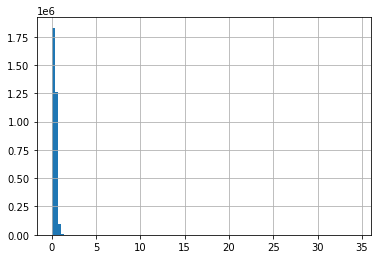

In [55]:
merge2_df['토지면적대연면적비'].hist(bins=100)

In [56]:
q1 = merge2_df['토지면적대연면적비'].quantile(0.25)
q3 = merge2_df['토지면적대연면적비'].quantile(0.75)
iqr = q3 - q1
outlier_step = iqr * 7
outlier_df = merge2_df[merge2_df['토지면적대연면적비'] > 7]
outlier_df.shape

(80, 312)

<AxesSubplot:>

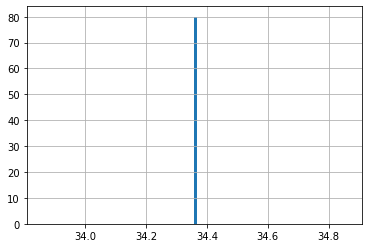

In [57]:
outlier_df['토지면적대연면적비'].hist(bins=100)

<AxesSubplot:>

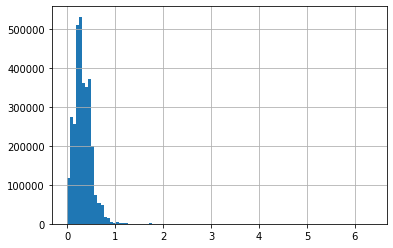

In [58]:
merge2_df = merge2_df.drop(outlier_df.index).reset_index(drop=True)
merge2_df['토지면적대연면적비'].hist(bins=100)

<AxesSubplot:>

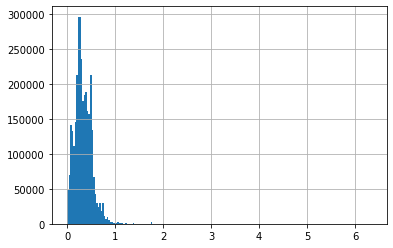

In [59]:
merge2_df['토지면적대연면적비'].hist(bins=200)

In [60]:
outlier_df = merge2_df[merge2_df['토지면적대연면적비'] > 1.5]

<AxesSubplot:>

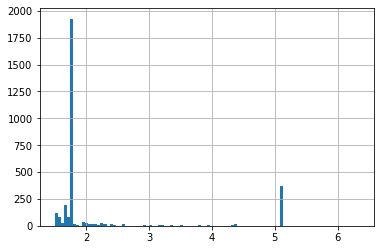

In [61]:
outlier_df['토지면적대연면적비'].hist(bins=100)

In [62]:
merge2_df = merge2_df.drop(outlier_df.index)

<AxesSubplot:>

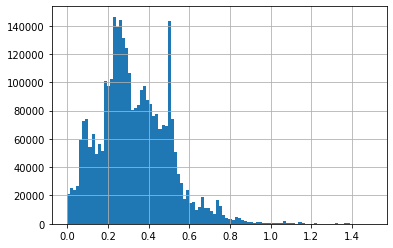

In [65]:
merge2_df['토지면적대연면적비'].hist(bins=100)

<AxesSubplot:>

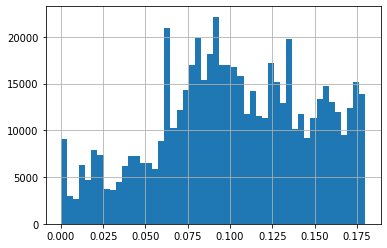

In [66]:
outlier_df = merge2_df[merge2_df['토지면적대연면적비'] < 0.18]
outlier_df['토지면적대연면적비'].hist(bins=50)

In [67]:
merge2_df = merge2_df.drop(outlier_df.index).reset_index(drop=True)
merge2_df.shape

(2619444, 312)

In [69]:
merge2_df['토지연면적비곱공시지가'] = merge2_df['공시지가(만원)'] * merge2_df['토지면적대연면적비']

In [70]:
merge3_df = merge2_df.merge(land_plans_df, on=['지번주소', '년'])
merge3_df.shape

(2619265, 599)

In [71]:
merge3_df = merge3_df.merge(bdsubnum_df, on=['지번주소', '년'])
merge3_df.shape

(2619265, 600)

In [72]:
merge3_df.drop(columns=['지번주소'], inplace=True)

In [73]:
merge3_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','').replace('ㆍ','_').replace(' ','_') for col in merge3_df.columns]

In [74]:
land_plans_df.columns = [col.replace(':','').replace('/','').replace('\\','').replace('*','').replace('?','').replace('\"','')\
                     .replace('|','').replace('<','').replace('>','').replace('ㆍ','_').replace(' ','_') for col in land_plans_df.columns]

In [75]:
lp_catcols = land_plans_df.columns.tolist()[2:]
lp_catcols[:5]

['(한강)오염행위_제한지역', '(한강)폐기물매립시설_설치제한지역', '4대문안', '가로구역별_최고높이_제한지역', '가스공급설비']

In [76]:
ls_catcols = [col for col in cols if col not in ['지번주소', '년', '토지면적']]
ls_catcols

['지목명', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '도로접면']

In [77]:
merge3_df['전용면적'] = merge3_df['전용면적'].apply(np.log1p)

In [78]:
merge3_df['토지면적'] = merge3_df['토지면적'].apply(np.log1p)

In [79]:
merge3_df['연면적'] = merge3_df['연면적'].apply(np.log1p)

In [80]:
merge3_df.drop(columns=['년'], inplace=True)

In [81]:
def building_age_feature_engi(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        
        if x < 0:
            return '건축전계약'
        elif x < 5:
            return '5년미만'
        elif x < 10:
            return '10년미만'
        elif x < 15:
            return '15년미만'
        elif x < 20:
            return '20년미만'
        elif x < 30:
            return '30년미만'
        elif x < 40:
            return '40년미만'
        else:
            return '40년이상'

In [82]:
merge3_df['건물나이'] = merge3_df['건물나이'].apply(building_age_feature_engi)
merge3_df['건물나이'].value_counts()

30년미만    583937
15년미만    483348
10년미만    452710
5년미만     445491
20년미만    440893
40년미만    191322
40년이상     21557
건축전계약         7
Name: 건물나이, dtype: int64

In [83]:
cat_cols = ['trade_type', '표준지여부', '건물나이'] + ls_catcols + lp_catcols

In [84]:
for col in tqdm(cat_cols):
    col_map = {}
    col_map_df = pd.DataFrame({'cat':merge3_df[col].unique(),'map':[i for i in range(len(merge3_df[col].unique()))]})
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    merge3_df[col] = merge3_df[col].map(col_map)
    col_map_df.to_csv('./Training/training_data_ver_14/feature_maps/{}_map.csv'.format(col))

100%|████████████████████████████████████████████████████████████████████████████████| 296/296 [06:17<00:00,  1.27s/it]


In [85]:
cat_cols_df = pd.DataFrame({'colname':cat_cols})
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,건물나이
3,지목명
4,용도지역명1


In [86]:
cat_cols_df.to_csv('./Training/training_data_ver_14/cat_cols.csv', index=False)

In [87]:
cols_to_drop = []
for col in tqdm(merge3_df.columns):
    try:
        if merge3_df[col].std() == 0:
            cols_to_drop.append(col)
        else:
            pass
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [00:17<00:00, 33.44it/s]


In [88]:
len(cols_to_drop)

77

In [89]:
cols_to_drop

['주_용도_일반게임제공업의시설_있음',
 '주_용도_기타일반숙박시설_있음',
 '주_용도_가족호텔_있음',
 '주_용도_기타생활권수련시설_있음',
 '주_용도_일반업무시설_있음',
 '주_용도_기타발전시설_있음',
 '주_용도_제1종근린생활시설_있음',
 '주_용도_안마시술소_있음',
 '주_용도_극장_있음',
 '주_용도_극장(영화관)_있음',
 '주_용도_교육연구시설_있음',
 '주_용도_대형백화점_있음',
 '주_용도_총포판매사_있음',
 '주_용도_대형점_있음',
 '주_용도_유원시설업의시설_있음',
 '주_용도_무도장_있음',
 '주_용도_안마원_있음',
 '주_용도_대학_있음',
 '주_용도_주점영업_있음',
 '주_용도_요양병원_있음',
 '주_용도_매매장_있음',
 '주_용도_테니스장_있음',
 '주_용도_무도장(학원)_있음',
 '주_용도_대학교_있음',
 '주_용도_호텔_있음',
 '주_용도_복합유통게임제공업의시설_있음',
 '주_용도_영화관_있음',
 '주_용도_도매시장_있음',
 '주_용도_정비공장_있음',
 '주_용도_복합유통게임제공업소_있음',
 '주_용도_회의장_있음',
 '주_용도_군사시설_있음',
 '주_용도_방송국_있음',
 '주_용도_기타동식물관련시설_있음',
 '주_용도_검사장_있음',
 '주_용도_기타관광숙박시설_있음',
 '주_용도_위험물취급소_있음',
 '주_용도_석유판매소_있음',
 '주_용도_물놀이형시설_있음',
 '주_용도_유해공장_있음',
 '주_용도_주유소_있음',
 '주_용도_다중생활시설_있음',
 '주_용도_일반숙박시설_있음',
 '주_용도_호스텔_있음',
 '주_용도_박물관_있음',
 '주_용도_생활숙박시설_있음',
 '주_용도_청소년문화의집_있음',
 '주_용도_근린생활시설_있음',
 '주_용도_액화가스판매소_있음',
 '주_용도_신문사_있음',
 '주_용도_음악당_있음',
 '주_용도_냉동창고_있음',
 '주_용도_놀이형시설_있음',
 '주_용도_기타게임시설_있음',
 '주_용도_비디오물소극장_있음'

In [90]:
merge3_df.drop(columns=cols_to_drop, inplace=True)

In [91]:
%%time
merge3_df.to_csv('./Training/training_data_ver_14/training_data_ver_14.csv', index=False)

Wall time: 12min 38s
